In [10]:
import matplotlib.pyplot as plt
import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import precision_recall_curve, roc_curve, accuracy_score, confusion_matrix, precision_score, recall_score
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 
import seaborn as sns 
plt.style.use('fivethirtyeight')
import pickle 
import os 
import numpy as np
import cv2 
%matplotlib inline


In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
train_dir= "/content/drive/MyDrive/dataset/chest_xray/train"
val_dir = "/content/drive/MyDrive/dataset/chest_xray/val"
test_dir = "/content/drive/MyDrive/dataset/chest_xray/test"

In [4]:
img_Datagen = ImageDataGenerator(
        rescale = 1/255,
        shear_range=10,
        zoom_range=0.3,
        horizontal_flip=True,
        vertical_flip=True,
        brightness_range=[0.5,2.0],
        width_shift_range = 0.2,
        rotation_range=20,
        fill_mode = 'nearest'
)
val_Datagen = ImageDataGenerator(
        rescale = 1/255
)

In [7]:
train = img_Datagen.flow_from_directory(train_dir,
                                       batch_size=32,
                                       class_mode='binary',
#                                        target_size=(224,224,3))
                                       )

validation = val_Datagen.flow_from_directory(val_dir,
                                              batch_size=2,
                                              class_mode='binary',
#                                               target_size=(224,224,3))
                                            )

test = val_Datagen.flow_from_directory(test_dir,
                                       batch_size=2,
                                       class_mode='binary',
#                                        target_size=(224/,224,3))
                                      )

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


##VGG19

In [ ]:
vgg_model = tf.keras.applications.VGG19(
    weights='imagenet',
    include_top = False,
#     input_shape = (224,224,3)
)

for layer in vgg_model.layers:
    layer.trainable=False
    
x = vgg_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128,activation='relu')(x)
# output layer
predictions = tf.keras.layers.Dense(1,activation='sigmoid')(x)

model = tf.keras.Model(inputs=vgg_model.input, outputs=predictions)

# to avoid overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=7)
lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',patience=5)

# Compiling the model
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

80134624/80134624 [==============================] - 4s 0us/step


In [ ]:
history = model.fit(train,epochs=10, 
                    validation_data=validation,
                     steps_per_epoch=50,
                    callbacks=[early_stopping,lr],
                    batch_size=32)

Epoch 1/10
50/50 [==============================] - 959s 19s/step - loss: 0.5216 - accuracy: 0.7606 - val_loss: 0.6070 - val_accuracy: 0.5625 - lr: 0.0010
Epoch 2/10
50/50 [==============================] - 619s 12s/step - loss: 0.4755 - accuracy: 0.7644 - val_loss: 0.4979 - val_accuracy: 0.6875 - lr: 0.0010
Epoch 3/10
50/50 [==============================] - 432s 9s/step - loss: 0.4561 - accuracy: 0.7750 - val_loss: 0.4910 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 4/10
50/50 [==============================] - 310s 6s/step - loss: 0.4203 - accuracy: 0.8025 - val_loss: 0.4742 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 5/10
50/50 [==============================] - 238s 5s/step - loss: 0.4175 - accuracy: 0.8000 - val_loss: 0.4796 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 6/10
50/50 [==============================] - 183s 4s/step - loss: 0.3895 - accuracy: 0.8219 - val_loss: 0.4611 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 7/10
50/50 [==============================] - 142s 3s/step - loss: 0

In [ ]:
# Evaluating the model on train and test
score = model.evaluate(train)

print("Train Loss: ", score[0])
print("Train Accuracy: ", score[1])

163/163 [==============================] - 227s 1s/step - loss: 0.3349 - accuracy: 0.8543
Train Loss:  0.33493277430534363
Train Accuracy:  0.85429447889328


In [ ]:
# Test data
score = model.evaluate(test)

print("Test Loss: ", score[0])
print("Test Accuracy: ", score[1])

312/312 [==============================] - 388s 1s/step - loss: 0.4423 - accuracy: 0.8221
Test Loss:  0.44229674339294434
Test Accuracy:  0.8221153616905212


**fine-tuning**

In [ ]:
vgg_model.trainable = True

In [ ]:
print("Number of layers in the base model: ", len(vgg_model.layers))
# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in vgg_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  22


In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

In [ ]:
fine_tune_epochs = 10
epochs_on_raw_model = 10

total_epochs =  epochs_on_raw_model + fine_tune_epochs

history_fine =model.fit(train,epochs=total_epochs, 
                    validation_data=validation,
                    steps_per_epoch=50,
                    callbacks=[early_stopping,lr],
                    batch_size=32)

Epoch 1/20
50/50 [==============================] - 51s 979ms/step - loss: 0.3389 - accuracy: 0.8487 - val_loss: 0.4288 - val_accuracy: 0.8125 - lr: 0.0010
Epoch 2/20
50/50 [==============================] - 49s 971ms/step - loss: 0.3416 - accuracy: 0.8438 - val_loss: 0.4234 - val_accuracy: 0.8125 - lr: 0.0010
Epoch 3/20
50/50 [==============================] - 48s 957ms/step - loss: 0.3200 - accuracy: 0.8531 - val_loss: 0.5120 - val_accuracy: 0.6875 - lr: 0.0010
Epoch 4/20
50/50 [==============================] - 48s 958ms/step - loss: 0.3516 - accuracy: 0.8400 - val_loss: 0.4350 - val_accuracy: 0.8125 - lr: 0.0010
Epoch 5/20
50/50 [==============================] - 50s 990ms/step - loss: 0.3022 - accuracy: 0.8675 - val_loss: 0.4337 - val_accuracy: 0.8125 - lr: 0.0010
Epoch 6/20
50/50 [==============================] - 50s 995ms/step - loss: 0.3173 - accuracy: 0.8556 - val_loss: 0.4339 - val_accuracy: 0.8125 - lr: 0.0010
Epoch 7/20
50/50 [==============================] - 49s 984ms/st

In [ ]:
score = model.evaluate(train)

print("Train Loss: ", score[0])
print("Train Accuracy: ", score[1])

score = model.evaluate(test)
print("\nTest loss: ", score[0])
print("Test Accuracy: ", score[1])

163/163 [==============================] - 160s 982ms/step - loss: 0.2596 - accuracy: 0.8924
Train Loss:  0.25959429144859314
Train Accuracy:  0.8924463391304016
312/312 [==============================] - 10s 31ms/step - loss: 0.3559 - accuracy: 0.8526

Test loss:  0.35586312413215637
Test Accuracy:  0.8525640964508057


Text(0.5, 1.0, 'Accuracy Evolution')

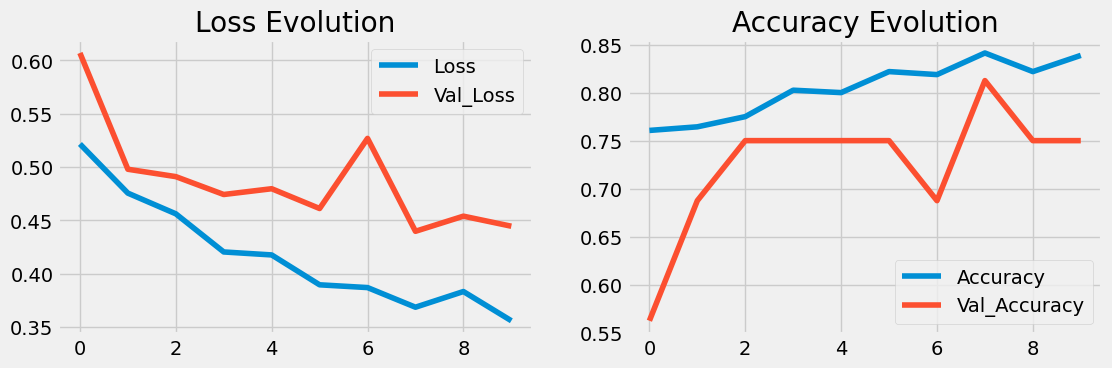

In [ ]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val_Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

In [ ]:
image_shape=(128,128,3)
train_image_gen = img_Datagen.flow_from_directory(train_dir,
                                                target_size=image_shape[:2],
                                                color_mode='rgb',
                                                batch_size=16,
                                                class_mode='binary')
test_image_gen = img_Datagen.flow_from_directory(test_dir,
                                               target_size=image_shape[:2],
                                               color_mode='rgb',
                                               batch_size=16,
                                               class_mode='binary',
                                               shuffle=False)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


**Evaluate the mode**

In [ ]:
model.evaluate(test_image_gen, verbose=0)

[0.9289563298225403, 0.6330128312110901]

**evaluation report**


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
y_pred = model.predict(test_image_gen)
y_pred = y_pred.round()
y_true = test_image_gen.classes
print(classification_report(y_true,y_pred))

39/39 [==============================] - 10s 258ms/step
              precision    recall  f1-score   support

           0       0.51      0.35      0.41       234
           1       0.67      0.80      0.73       390

    accuracy                           0.63       624
   macro avg       0.59      0.57      0.57       624
weighted avg       0.61      0.63      0.61       624



**confusion matrix**


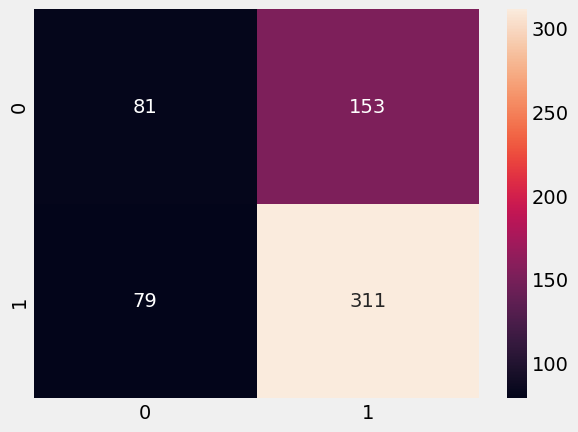

In [ ]:
import seaborn as sns
cnf = confusion_matrix(y_true,y_pred)
sns.heatmap(cnf, annot=True, fmt='g')
plt.show()

**ROC curve**


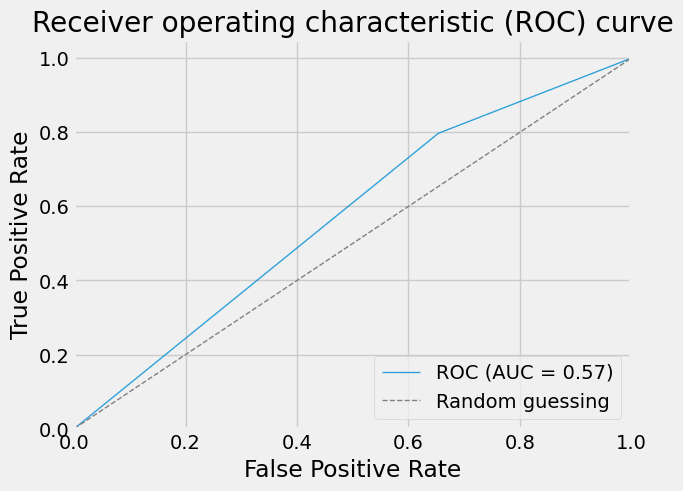

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1, alpha=0.8, label='ROC (AUC = %0.2f)' % (roc_auc))
plt.plot([0, 1], [0, 1], linestyle='--', lw=1, color='gray', label='Random guessing')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()

**saving the model**

In [ ]:
model.save('tuned_vgg19.h5')

NameError: ignored

**loading the model**

In [ ]:
final_model = tf.keras.models.load_model('tuned_vgg19.h5')

In [ ]:
final_model.evaluate(test)

312/312 [==============================] - 10s 32ms/step - loss: 0.3559 - accuracy: 0.8526


[0.3558632731437683, 0.8525640964508057]

**testing the model**


1/1 [==============================] - 0s 18ms/step
Prediction: Pneumonia


Text(0.5, 1.0, 'Prediction: Pneumonia')

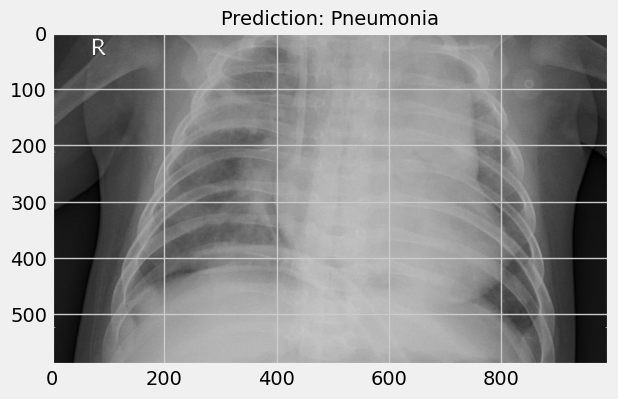

In [ ]:
img= cv2.imread('/content/drive/MyDrive/dataset/chest_xray/test/PNEUMONIA/person104_bacteria_492.jpeg')
tempimg = img
img = cv2.resize(img,(300,300))
img = img/255.0
img = img.reshape(1,300,300,3)
final_model.predict(img)
prediction = final_model.predict(img) >= 0.5
if prediction>=0.5:
  prediction = "Pneumonia"
else:
  prediction = "Normal"
print("Prediction: "+prediction)
plt.imshow(tempimg)
plt.title("Prediction: "+prediction, fontsize=14)

1/1 [==============================] - 0s 35ms/step
Prediction: Normal


Text(0.5, 1.0, 'Prediction: Normal')

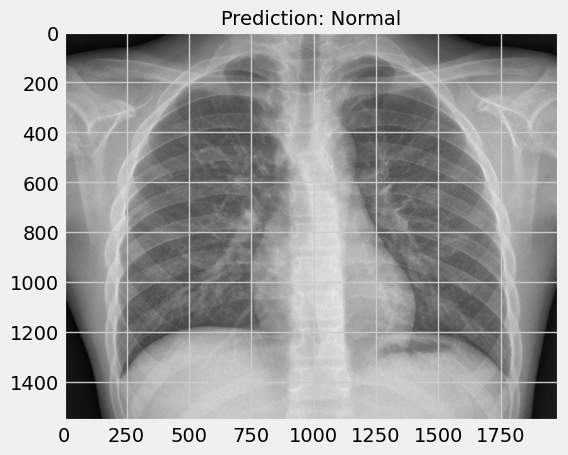

In [ ]:
img= cv2.imread('/content/drive/MyDrive/dataset/chest_xray/test/NORMAL/IM-0017-0001.jpeg')
tempimg = img
img = cv2.resize(img,(300,300))
img = img/255.0
img = img.reshape(1,300,300,3)
model.predict(img)
prediction = model.predict(img) >= 0.5
if prediction>=0.5:
  prediction = "Pneumonia"
else:
  prediction = "Normal"
print("Prediction: "+prediction)
plt.imshow(tempimg)
plt.title("Prediction: "+prediction, fontsize=14)

1/1 [==============================] - 0s 30ms/step
Prediction: Pneumonia


Text(0.5, 1.0, 'Prediction: Pneumonia')

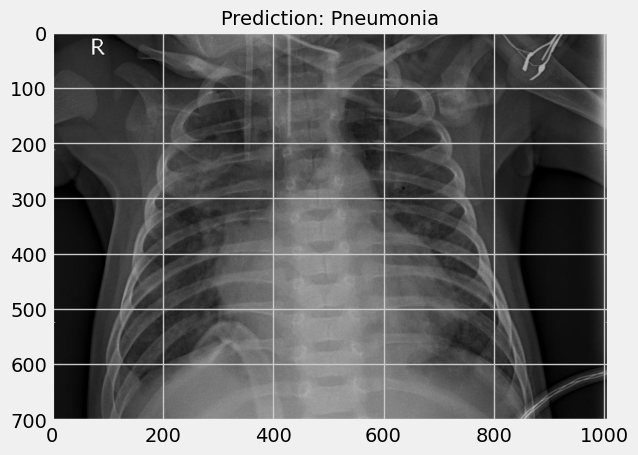

In [ ]:
img= cv2.imread('/content/drive/MyDrive/dataset/chest_xray/test/PNEUMONIA/person94_bacteria_456.jpeg')
tempimg = img
img = cv2.resize(img,(300,300))
img = img/255.0
img = img.reshape(1,300,300,3)
model.predict(img)
prediction = model.predict(img) >= 0.5
if prediction>=0.5:
  prediction = "Pneumonia"
else:
  prediction = "Normal"
print("Prediction: "+prediction)
plt.imshow(tempimg)
plt.title("Prediction: "+prediction, fontsize=14)

**

##MOBILENET

In [ ]:
mobilenet_model = tf.keras.applications.MobileNetV2(
    weights='imagenet',
    include_top = False,
input_shape = (224,224,3)
)

for layer in mobilenet_model.layers:
    layer.trainable=False
    
x = mobilenet_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128,activation='relu')(x)
# output layer
predictions = tf.keras.layers.Dense(1,activation='sigmoid')(x)

model2 = tf.keras.Model(inputs=mobilenet_model.input, outputs=predictions)

# to avoid overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=10)
lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',patience=8)

# Compiling the model
model2.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

In [ ]:
history = model2.fit(train,epochs=15, 
                    validation_data=validation,
                     steps_per_epoch=50,
                    callbacks=[early_stopping,lr],
                    batch_size=32)

Epoch 1/15
50/50 [==============================] - 58s 1s/step - loss: 0.3665 - accuracy: 0.8481 - val_loss: 0.2261 - val_accuracy: 0.9375 - lr: 0.0010
Epoch 2/15
50/50 [==============================] - 52s 1s/step - loss: 0.2461 - accuracy: 0.8919 - val_loss: 0.1784 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 3/15
50/50 [==============================] - 54s 1s/step - loss: 0.2336 - accuracy: 0.9031 - val_loss: 0.4008 - val_accuracy: 0.8125 - lr: 0.0010
Epoch 4/15
50/50 [==============================] - 52s 1s/step - loss: 0.2266 - accuracy: 0.8994 - val_loss: 0.8889 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 5/15
50/50 [==============================] - 53s 1s/step - loss: 0.2182 - accuracy: 0.9150 - val_loss: 0.4621 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 6/15
50/50 [==============================] - 51s 1s/step - loss: 0.2028 - accuracy: 0.9125 - val_loss: 0.2697 - val_accuracy: 0.8125 - lr: 0.0010
Epoch 7/15
50/50 [==============================] - 52s 1s/step - loss: 0.1987 - a

In [ ]:
# Evaluating the model on train and test
score = model2.evaluate(train)

print("Train Loss: ", score[0])
print("Train Accuracy: ", score[1])

score = model2.evaluate(test)
print("\nTest loss: ", score[0])
print("Test Accuracy: ", score[1])

163/163 [==============================] - 166s 1s/step - loss: 0.1702 - accuracy: 0.9310
Train Loss:  0.1702066957950592
Train Accuracy:  0.9309815764427185
312/312 [==============================] - 10s 34ms/step - loss: 0.2556 - accuracy: 0.9087

Test loss:  0.2556113600730896
Test Accuracy:  0.9086538553237915


**fine tuning**


In [ ]:
mobilenet_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(mobilenet_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in mobilenet_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [ ]:
model2.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

In [ ]:
fine_tune_epochs = 10
epochs_on_raw_model = 15

total_epochs =  epochs_on_raw_model + fine_tune_epochs

history_fine =model2.fit(train,epochs=total_epochs, 
                    validation_data=validation,
                    steps_per_epoch=50,
                    callbacks=[early_stopping,lr],
                    batch_size=32)

Epoch 1/25
50/50 [==============================] - 52s 1s/step - loss: 0.2445 - accuracy: 0.9000 - val_loss: 21.1333 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/25
50/50 [==============================] - 52s 1s/step - loss: 0.1808 - accuracy: 0.9312 - val_loss: 14.6969 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/25
50/50 [==============================] - 52s 1s/step - loss: 0.1978 - accuracy: 0.9294 - val_loss: 6.3407 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/25
50/50 [==============================] - 52s 1s/step - loss: 0.1401 - accuracy: 0.9481 - val_loss: 3.8169 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 5/25
50/50 [==============================] - 52s 1s/step - loss: 0.1737 - accuracy: 0.9281 - val_loss: 0.0999 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 6/25
50/50 [==============================] - 50s 1s/step - loss: 0.1312 - accuracy: 0.9469 - val_loss: 1.9484 - val_accuracy: 0.5625 - lr: 0.0010
Epoch 7/25
50/50 [==============================] - 52s 1s/step - loss: 0.1437 -

In [ ]:
# Evaluating the model on train and test
score = model2.evaluate(train)

print("Train Loss: ", score[0])
print("Train Accuracy: ", score[1])

score = model2.evaluate(test)
print("\nTest loss: ", score[0])
print("Test Accuracy: ", score[1])

163/163 [==============================] - 165s 1s/step - loss: 3.0515 - accuracy: 0.7450
Train Loss:  3.051450729370117
Train Accuracy:  0.7450153231620789
312/312 [==============================] - 11s 35ms/step - loss: 4.0895 - accuracy: 0.6250

Test loss:  4.089541912078857
Test Accuracy:  0.625


**evaluation plots**

Text(0.5, 1.0, 'Accuracy Evolution')

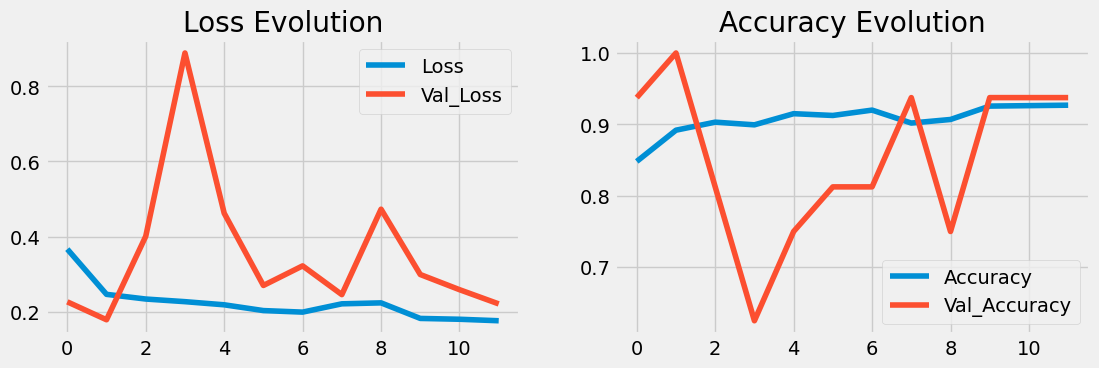

In [ ]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val_Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

**evaluation report**

In [ ]:
image_shape=(224,224,3)
train_image_gen = img_Datagen.flow_from_directory(train_dir,
                                                target_size=image_shape[:2],
                                                color_mode='rgb',
                                                batch_size=16,
                                                class_mode='binary')
test_image_gen = img_Datagen.flow_from_directory(test_dir,
                                               target_size=image_shape[:2],
                                               color_mode='rgb',
                                               batch_size=16,
                                               class_mode='binary',
                                               shuffle=False)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
y_pred = model2.predict(test_image_gen)
y_pred = y_pred.round()
y_true = test_image_gen.classes
print(classification_report(y_true,y_pred))

39/39 [==============================] - 19s 410ms/step
              precision    recall  f1-score   support

           0       0.88      0.72      0.80       234
           1       0.85      0.94      0.89       390

    accuracy                           0.86       624
   macro avg       0.87      0.83      0.84       624
weighted avg       0.86      0.86      0.86       624



**confusion matrix**

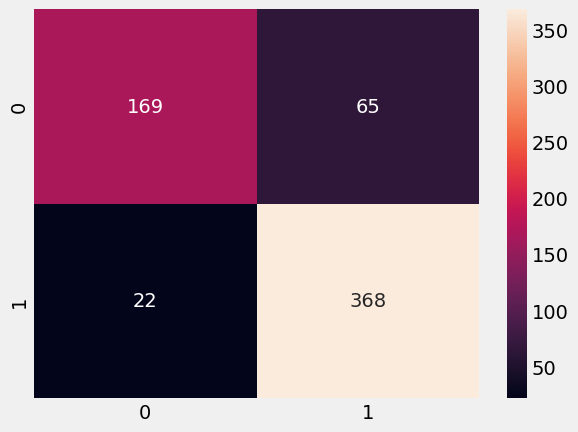

In [ ]:
import seaborn as sns
cnf = confusion_matrix(y_true,y_pred)
sns.heatmap(cnf, annot=True, fmt='g')
plt.show()

**ROC curve**

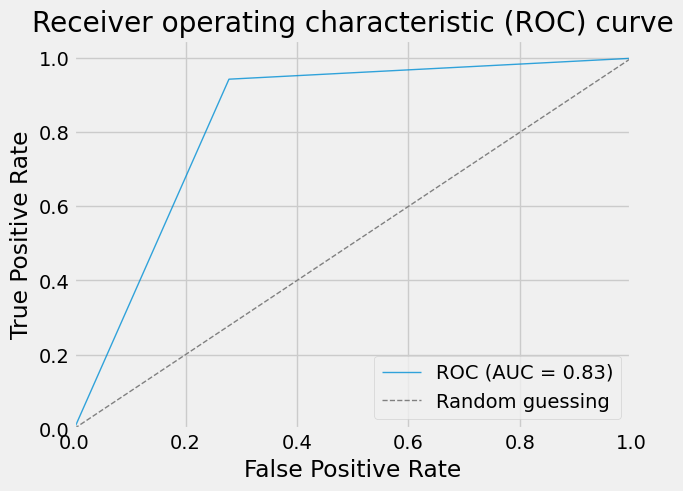

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1, alpha=0.8, label='ROC (AUC = %0.2f)' % (roc_auc))
plt.plot([0, 1], [0, 1], linestyle='--', lw=1, color='gray', label='Random guessing')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()

**saving the model**


In [ ]:
model2.save('without tuned_mobilenet.h5')

**loading the model**


In [ ]:
final_model2 = tf.keras.models.load_model('without tuned_mobilenet.h5')

In [ ]:
final_model2.evaluate(test)

312/312 [==============================] - 12s 34ms/step - loss: 0.2556 - accuracy: 0.9087


[0.2556113302707672, 0.9086538553237915]

**testing the model**

1/1 [==============================] - 0s 90ms/step
Prediction: Pneumonia


Text(0.5, 1.0, 'Prediction: Pneumonia')

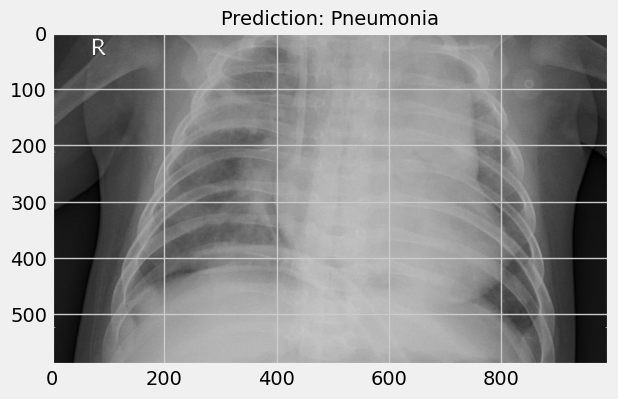

In [ ]:
img= cv2.imread('/content/drive/MyDrive/dataset/chest_xray/test/PNEUMONIA/person104_bacteria_492.jpeg')
tempimg = img
img = cv2.resize(img,(224,224))
img = img/255.0
img = img.reshape(1,224,224,3)
final_model2.predict(img)
prediction = final_model2.predict(img) >= 0.5
if prediction>=0.5:
  prediction = "Pneumonia"
else:
  prediction = "Normal"
print("Prediction: "+prediction)
plt.imshow(tempimg)
plt.title("Prediction: "+prediction, fontsize=14)